# 1. Preprocessing & Dataset setup
Loading ImageNet validation set & creating the Catfish dataset (details in utils.py and classes.py files)

In [1]:
# auto-refresh local imports
%load_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
import torch.nn as nn
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import utils
import random

/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys

COLAB = 'google.colab' in sys.modules

if COLAB:
    print("In Colab!")

if torch.cuda.is_available():
    print("using GPU!")
else:
    print("using CPU!")

using GPU!


In [4]:
# Check total GPU memory
total_memory = torch.cuda.get_device_properties(0).total_memory

# Check allocated memory
allocated_memory = torch.cuda.memory_allocated(0)

# Check cached memory (allocated + cached)
cached_memory = torch.cuda.memory_reserved(0)

print(f"Total GPU memory: {total_memory / 1e9:.2f} GB")
print(f"Allocated GPU memory: {allocated_memory / 1e9:.2f} GB")
print(f"Cached GPU memory: {cached_memory / 1e9:.2f} GB")

Total GPU memory: 6.44 GB
Allocated GPU memory: 0.00 GB
Cached GPU memory: 0.00 GB


### Car classes and CatFish classes are the same as those used in "Automatic Discovery for Visual Circuits"
Though, sub-label combinations making up the labels are different (as it is arbitrary)

In [5]:
IMAGE_FILEPATH = "./imagenet/imagenet_images/"
LABEL_FILEPATH = "./imagenet/imagenet_devkit/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
CLASS_FILEPATH = "imagenet_classes_val.txt"
TV_CLASS_FILEPATH = "imagenet_classes_tv.txt" # torchvision's class mapping for InceptionV1 (different from ImageNet training)
DRIVE_PATH = "content/drive/MyDrive" if COLAB else "."
IMG_SHAPE = (224, 224)
RANDOM_SEED = 42

# cab, minivan, sports car, pickup (respectively)
CAR_IDS = [267, 271, 274, 281]

# tabby(174), joystick(560), sports_car(274), loafer(973), shopping_cart(259),
# guillotine(517), tench(449), hot_pot(771), pajama(759), petridish(783) 
CATFISH_IDS = [174, 560, 274, 973, 259, 517, 449, 771, 759, 783] # 10 unique classes, 2 for each instance, denote labels

random.seed(RANDOM_SEED)

# function to shaw images
def show_img(image):
    img = image.clone()
    if len(img.shape) == 4: # assuming batch dim is [0]
        img.squeeze(0)
    tfm = torchvision.transforms.ToPILImage()
    _img = tfm(img)
    _img.show()

In [6]:
labels = utils.load_labels(LABEL_FILEPATH)

# Load the CAR classes
car_images, car_labels_idx = utils.load_class_images_from_id(IMAGE_FILEPATH, labels, class_id=CAR_IDS, force_shape_to=IMG_SHAPE)
print(len(car_images)) # should be 200

# Load the CATFISH subclasses
catfish_subimages, catfish_labels_idx = utils.load_class_images_from_id(IMAGE_FILEPATH, labels, class_id=CATFISH_IDS, force_shape_to=IMG_SHAPE)
print(len(catfish_subimages)) # should be 500

/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


200
500


In [7]:
import torchvision.transforms.v2 as T

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

CATFISH_DATASET_PATH = os.path.join("./catfish", "images")

# Create CatFish dataset and labels .txt file
if os.path.exists('./catfish'):
    transforms = T.Compose([
        T.Resize(IMG_SHAPE),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
    )

    catfish_loader = torchvision.datasets.ImageFolder(
        CATFISH_DATASET_PATH,
        transform=transforms,
    )
    catfish_class_names = sorted(os.listdir(CATFISH_DATASET_PATH))
else:
    # if not already curated (NOTE: takes a while to run)
    catfish_loader, catfish_class_names = utils.create_catfish_dataset(
        catfish_subimages,
        catfish_labels_idx,
        CLASS_FILEPATH,
        "./catfish",
        random_seed=RANDOM_SEED, # we ran this using '42' as our random seed
    )
    
# newlabels: {'tabby-shoppingcart': [174, 259], 'tabby-guillotine': [174, 517], 'shoppingcart-tench': [259, 449], 'shoppingcart-sportscar': [259, 274], 'sportscar-petridish': [274, 783], 'sportscar-loafer': [274, 973], 'tench-pajama': [449, 759], 'tench-tabby': [449, 174], 'guillotine-shoppingcart': [517, 259], 'guillotine-tench': [517, 449], 'joystick-tench': [560, 449], 'joystick-petridish': [560, 783], 'pajama-loafer': [759, 973], 'pajama-tabby': [759, 174], 'hotpot-petridish': [771, 783], 'hotpot-tench': [771, 449], 'petridish-pajama': [783, 759], 'petridish-tench': [783, 449], 'loafer-hotpot': [973, 771], 'loafer-guillotine': [973, 517]}

In [8]:
catfish_class_names

['guillotine-shoppingcart',
 'guillotine-tench',
 'hotpot-petridish',
 'hotpot-tench',
 'joystick-petridish',
 'joystick-tench',
 'loafer-guillotine',
 'loafer-hotpot',
 'pajama-loafer',
 'pajama-tabby',
 'petridish-pajama',
 'petridish-tench',
 'shoppingcart-sportscar',
 'shoppingcart-tench',
 'sportscar-loafer',
 'sportscar-petridish',
 'tabby-guillotine',
 'tabby-shoppingcart',
 'tench-pajama',
 'tench-tabby']

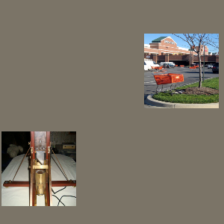

guillotine-shoppingcart


In [9]:
# can view any CatFish class we'd like:
class_idx = 250 # change this to view different indices
show_img(utils.denormalize(catfish_loader[class_idx][0])) # img
print(catfish_class_names[catfish_loader[class_idx][1]]) # label name

# 2. Visualization

Here, we test our visualization API (<b>classes.</b>ModelVisualizer) such that we can see explicit Dataset examples and maximally activating images (using optimization) to get some intuition in what our neuron/channel/layer is seeing.

In [10]:
from classes import ModelVisualizer, ImageDataset
from utils import normalize, denormalize

# Model to use with CLA and visualization
googlenet = torchvision.models.googlenet(weights='IMAGENET1K_V1') # inceptionV1
googlenet.eval()

# sample images from catfish subclasses sampled from the ImageNet validation set
imageds = ImageDataset(catfish_subimages, catfish_labels_idx)

# all layers that we can visualize/operate on
for name, layer in googlenet.named_children():
    print(name)

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


### Visualizing dataset examples that maximally activate the selected layer/channel/neuron
__NOTE:__ Some selections are solely zero-valued; this means visualization won't work for these components.
(Some do behave this way, but most do not.)

Top 3 activation values:  tensor([34057.0859, 33456.8594, 32484.0273])


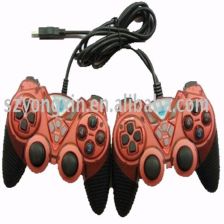

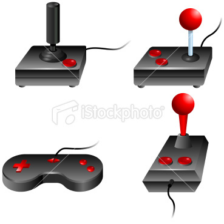

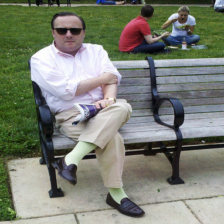

In [11]:
VISUALIZATION_LAYER = "inception4a"
VISUALIZATION_CHANNEL = 12
VISUALIZATION_NEURON = 10
TOP_K = 3

modelvis = ModelVisualizer(googlenet, device='cuda')

# Dataset examples
max_imgs, max_vals = modelvis.get_maximum_activations(imageds,
    topk=TOP_K,
    target_layer=VISUALIZATION_LAYER,
    # target_channel=VISUALIZATION_CHANNEL, 
    # target_neuron=VISUALIZATION_NEURON
)

# Display
print(f"Top {TOP_K} activation values: ", max_vals)
for img in imageds.images[max_imgs]:
    show_img(img)

### Visualizing (by optimization) the input that maximally activates the selected part of the model.

cuda:0


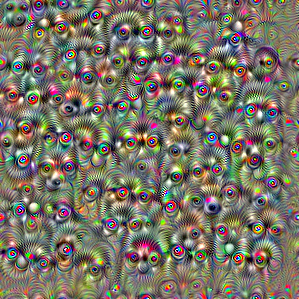

iteration:  299
activation:  tensor(177682.0938, device='cuda:0', grad_fn=<SumBackward0>)


In [12]:
test_visualization = modelvis.visualize_activations(
    target_layer=VISUALIZATION_LAYER,
    # target_channel=VISUALIZATION_CHANNEL, 
    # target_neuron=VISUALIZATION_NEURON, 
    lr=25.0, 
    max_iter=300,
    verbose_iters=None,
)

# 3. Automatic Circuit Extraction (__main algorithm__)

Now that we have our visualizations working, we can go forward with the CLA algorithm and ensure its correctness through reproducing the results of the experiment done in [14] Olah et al's "An Introduction to Circuits"

In the paper, they applied CLA to mixed 4b, 4c, and 4d. (We'll be doing the same)

Implementation details can be found in __classes__.CircuitExtractor

In [13]:
from classes import CircuitExtractor
import torch.cuda.amp as amp

START_LAYER = "inception4b"
END_LAYER = "inception4c"
K = 5

circuit_extractor = CircuitExtractor(googlenet, normalize(car_images[0:100]), device="cuda")
print(circuit_extractor.layer_names()) # list all the valid layers we can start/end from this model


['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'avgpool', 'dropout', 'fc']


In [14]:
circuit = circuit_extractor(START_LAYER, END_LAYER, K)
print(circuit)


RUNNING with k: 5  dim_type= init
MAX CHUNK SIZE: 5786
memcheck 4839178240
l1size: 100352, l2size: 100352
chunk_size: 5576 x18
torch.Size([5576, 100352])
chunk# 0
memcheck 2599419904
memcheck_after_rows 22093824
rows needs 100352 0 5576
selected neurons 'm': None
memcheck_acts 23011328
memcheck_inst 0 0
memcheck_acts 0
memcheck_inst 1 0
memcheck_acts 0
memcheck_inst 2 0
memcheck_acts 0
memcheck_inst 3 0
memcheck_acts 0
memcheck_inst 4 0
memcheck_acts 0
memcheck_inst 5 0
memcheck_acts 0
memcheck_inst 6 0
memcheck_acts 0
memcheck_inst 7 0
memcheck_acts 0
memcheck_inst 8 0
memcheck_acts 0
memcheck_inst 9 0
memcheck_acts 0
memcheck_inst 10 0
memcheck_acts 0
memcheck_inst 11 0
memcheck_acts 0
memcheck_inst 12 0
memcheck_acts 0
memcheck_inst 13 0
memcheck_acts 0
memcheck_inst 14 0
memcheck_acts 0
memcheck_inst 15 0
memcheck_acts 0
memcheck_inst 16 0
memcheck_acts 0
memcheck_inst 17 0
memcheck_acts 0
memcheck_inst 18 0
memcheck_acts 0
memcheck_inst 19 0
memcheck_acts 0
memcheck_inst 20 0
mem

### TODO: Apply CatFish with Inception
(Everything below was used to test the functionality of CircuitExtractor; ignore)

In [15]:
import gc

circuit = None
del circuit

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# used to test CircuitExtractor on a much smaller model

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # Define the lightweight sequential CNN model
# class LightweightCNN(nn.Module):
#     def __init__(self):
#         super(LightweightCNN, self).__init__()
#         # (N,3,14,14) => (N,512,14,14)
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding="same") # 0: 36
#         # (N,512,14,14) => (N,512,14,14)
#         self.conv2 = nn.Conv2d(in_channels=4, out_channels=12, kernel_size=3, stride=1, padding="same") # 1: 108
#         self.conv3 = nn.Conv2d(in_channels=12, out_channels=8, kernel_size=3, stride=1, padding="same") # 2: 72
#         # self.fc1 = nn.Linear(in_features=8*2*2, out_features=3)  # Assuming 1000 output classes

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         # x = x.view(-1, 8*3*3)
#         # x = self.fc1(x)
#         return x.view(x.size(0), -1)

# # Example usage
# test_model = LightweightCNN()
# test_model.eval()


[autoreload of classes failed: Traceback (most recent call last):
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/stone/miniconda3/envs/yolo/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 309, in update_f

LightweightCNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
)

In [ ]:
# for val, idx in attr:
#     print(val) # 512,14,14
#     m_pos = idx % (12*14*14)
#     # print in terms of neuron 'n' and 'm' in CHW format
#     print(f"N: {idx // (12*14*14)}, M: {m_pos} (or: C:{m_pos // (14*14)}, H:{((m_pos%12)% (14*14)) // 14}, W:{((m_pos%12)% (14*14)) % 14})")
#     # there are 12,544 possible 'n'; M is 

0.16492851078510284
N: 718, M: 1765 (or: C:147, H:0, W:1)
0.16492851078510284
N: 719, M: 198 (or: C:16, H:0, W:6)
0.16492851078510284
N: 719, M: 983 (or: C:81, H:0, W:11)
0.16492851078510284
N: 720, M: 201 (or: C:16, H:0, W:9)
0.16492851078510284
N: 719, M: 1768 (or: C:147, H:0, W:4)
